<center><h1>Environmental Audio AI<br><small>Examples</small></h1></center>
<br><br>

<center style="font-size:140%;">
    <strong>Toni Heittola</strong><br>
    <small>toni.heittola@tuni.fi</small>
</center>
<table><tr>
<td><img src="images/ARG_logo.png" alt="Drawing" style="width:350px;"/></td>
    <td><img src="images/marvel_logo.png" alt="Drawing" style="width:350px;"/></td>
<td><img src="images/TAU_logo.png" alt="Drawing" style="width:250px;"/></td>
</tr></table>

# Introduction

This presentation goes through the usage of **pretrained models** for sound classification and **adapting them** for specific classification tasks

## Outline

- Audio tagging with pretrained models:
    - PANNS
    - YAMNet
- Transfer learning with pretrained models
- Sound event detection


In [34]:
import os, sys
from IPython import display
from IPython.display import Audio
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=18,5
import numpy as np
import pandas as pd
import csv
import dcase_util
from dcase_util.containers import AudioContainer
from dcase_util.features import MelExtractor
from dcase_util.containers import AudioContainer
import librosa
import matplotlib.pyplot as plt
import sklearn
import time
%matplotlib inline

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_env')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

test_audio_filename = os.path.join('audio', 'speech_and_whistling.wav')
test_audio_16k = dcase_util.containers.AudioContainer().load(
    filename=test_audio_filename,
    fs=16000,
    mono=True
)

test_audio_32k = dcase_util.containers.AudioContainer().load(
    filename=test_audio_filename,
    fs=32000,
    mono=True
)

@tf.function
def load_audio(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1
    )
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    return wav

from codecarbon import EmissionsTracker, OfflineEmissionsTracker

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.ERROR)

# PANNS
**Large-scale pretrained audio neural networks for audio pattern recognition**

- State-of-the-art pretrained audio tagging model released in 2019
- Model architecture is inspired by [VGG](https://arxiv.org/abs/1409.1556) architecture, model (CNN14) has **80M parameters**
- Trained with [AudioSet](https://research.google.com/audioset/) dataset
    - Data collected from YouTube
    - 2M human-labeled 10-second clips organized into ontology with 632 sound classes
- Designed for single-channel audio with a 32kHz sampling rate
- Model outputs:
    - Score for **527 sound classes**
    - Per-analysis-frame embedding (2048 values)
- Two modes: Audio tagger and Sound event detector    

<small>Qiuqiang Kong, Yin Cao, Turab Iqbal, Yuxuan Wang, Wenwu Wang, and Mark D. Plumbley. "<strong>PANNS: Large-scale pretrained audio neural networks for audio pattern recognition.</strong>" IEEE/ACM Transactions on Audio, Speech, and Language Processing 28 (2020): 2880-2894. <a href="https://arxiv.org/pdf/1912.10211.pdf" target="_blank">PDF</a></small> 

## Example audio

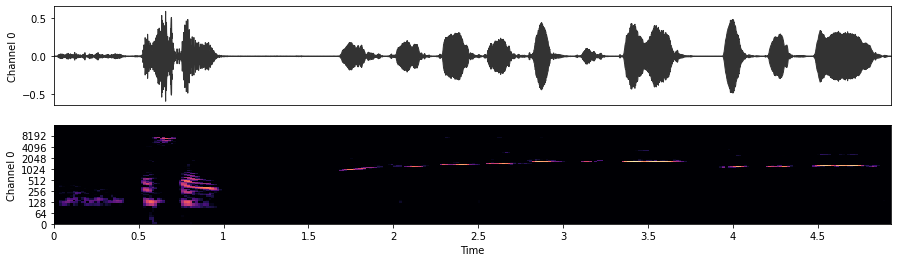

In [28]:
# Load test audio
test_audio_32k = AudioContainer().load(
    filename=test_audio_filename, 
    fs=32000, 
    mono=True
)
test_audio_32k.plot(plot_type='dual', show_filename=False, figsize=(15,4))
Audio(test_audio_32k.data, rate=test_audio_32k.fs)

## Usage as audio tagger

In [29]:
model_storage_filename = os.path.join('pretrained_models','panns_data','Cnn14_mAP=0.431.pth')

In [ ]:
# Import
from panns_inference import AudioTagging, labels

# Create audio tagger 
audio_tagger = AudioTagging(
    checkpoint_path=model_storage_filename, 
    device='cuda'
)
# Apply to test audio
(clipwise_output, embeddings) = audio_tagger.inference(
    test_audio_32k.data[None, :] # (batch_size, audio_samples)
)

Top 5 tags based on outputted scores:

In [31]:
sorted_indexes = np.argsort(clipwise_output[0])[::-1]
print('{score:} {tag}'.format(tag='Tag', score='Score'))
print('{score:} {tag}'.format(tag='-------', score='-----'))
# Print top 5 audio tags
for k in range(5):
    print('{score:.3f} {tag}'.format(
        tag=np.array(labels)[sorted_indexes[k]], 
        score=clipwise_output[0][sorted_indexes[k]])
    )

Score Tag
----- -------
0.724 Whistle
0.453 Whistling
0.334 Speech
0.079 Music
0.053 Inside, small room


## Usage as a sound event detector

In [ ]:
# Import
from panns_inference import SoundEventDetection, labels

# Create sound event detector
detector = SoundEventDetection(
    checkpoint_path=model_storage_filename, 
    device='cuda'
)
# Apply to test audio
framewise_output = detector.inference(test_audio_32k.data[None, :])

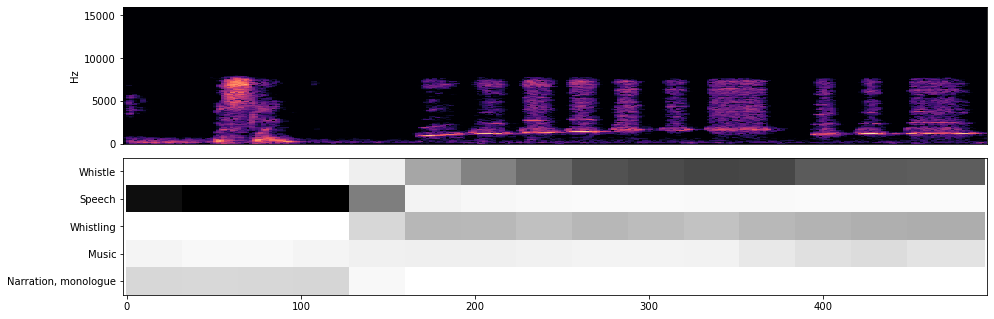

In [32]:
import librosa
top_n = 5
analysis_time_resolution = 320/32000 # sec

# Plot the waveform.
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(test_audio_32k.data)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=test_audio_32k.fs) #, ax=ax[0])
axes[0].get_xaxis().set_visible(False)

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(framewise_output[0,:,:], axis=0)

top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(2, 1, 2)
plt.imshow(framewise_output[0, :, top_class_indices], aspect='auto', interpolation='nearest', cmap='gray_r')

patch_padding = (0.032 / 2) / 0.01
plt.xlim([-patch_padding-0.5, framewise_output.shape[1] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [labels[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.1)

# YAMNet
**Pretrained neural network for sound recognition**

- Released by Google in 2019
- Model uses [Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) architecture
    - Depthwise-separable convolution architecture with **3.7M parameters**
- Trained with [AudioSet](https://research.google.com/audioset/) dataset
    - Data collected from YouTube
    - 2M human-labeled 10-second clips organized into ontology with 632 sound classes
- Designed for single-channel audio with a 16kHz sampling rate
    - Internally audio is framed into 0.96-second analysis window with 0.48 seconds hop
- Model outputs:
    - Score for **512 sound classes**
    - Per-analysis-frame embedding (1024 values)

## Usage

In [35]:
# Import
import tensorflow_hub as hub

# Load model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Load class names
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names = list(pd.read_csv(class_map_path)['display_name'])

# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(test_audio_16k.data)

In [36]:
print('scores matrix shape (analysis segments, class-wise scores):\n', scores.shape)

scores matrix shape (analysis segments, class-wise scores):
 (10, 521)


## Example audio

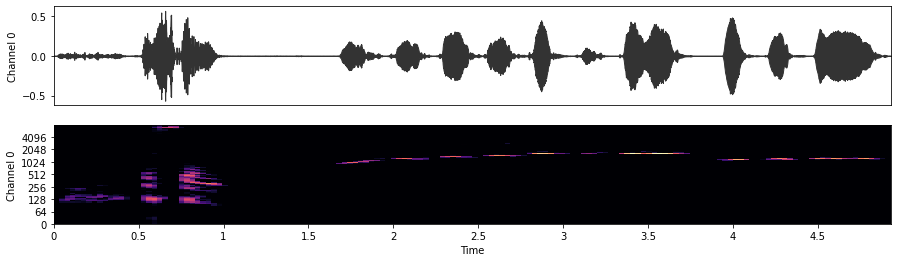

In [37]:
# Load test audio
test_audio_16k = dcase_util.containers.AudioContainer().load(
    filename=test_audio_filename, 
    fs=16000, 
    mono=True
)

test_audio_16k.plot(plot_type='dual', figsize=(15,4), show_filename=False)
display.Audio(test_audio_16k.data,rate=test_audio_16k.fs)

## Analyze content

In [38]:
# Run the model
scores, embeddings, spectrogram_data = yamnet_model(test_audio_16k.data)

# Get top class
infered_class = class_names[scores.numpy().mean(axis=0).argmax()]

In [39]:
print('infered_class:', infered_class)

infered_class: Whistle


## Scores of the top 5 classes across the sample

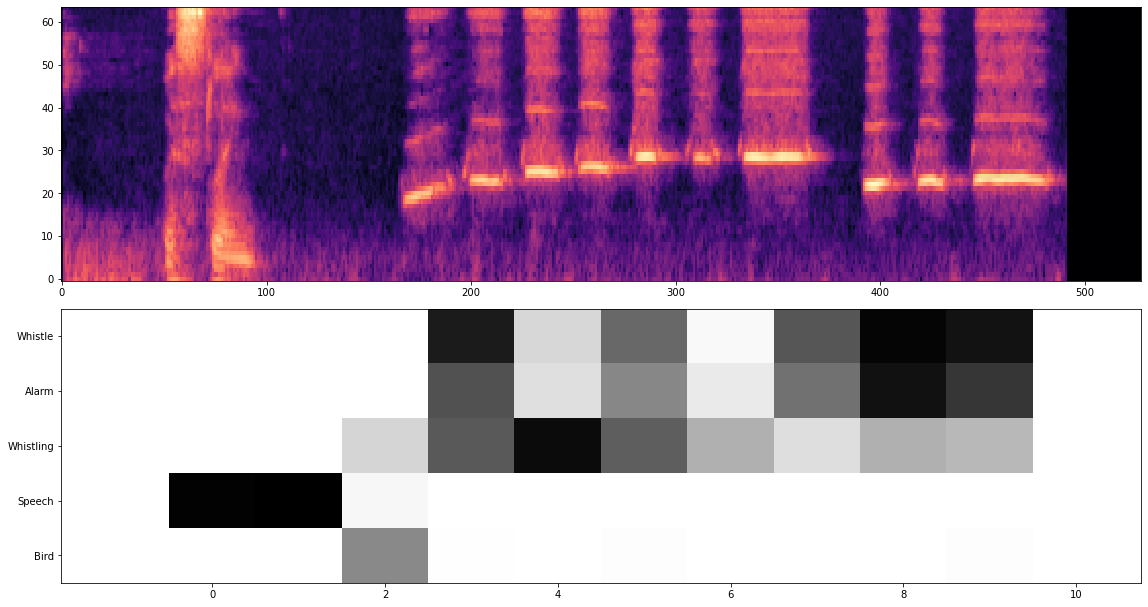

In [40]:
plt.figure(figsize=(15, 8))

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(2, 1, 1)
plt.imshow(spectrogram_data.numpy().T, aspect='auto', interpolation='nearest', origin='lower', cmap='magma')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores.numpy(), axis=0)
top_n = 5
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(2, 1, 2)
plt.imshow(scores.numpy()[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.1)

# Transfer Learning

*We need to make a robust classifier, however, we only have small amount of examples per class*

<img src="images/transfer_learning.png" width="800">


## Transfer Learning

**Advantage**: Many pre-trained models available, enables including a large amount of knowledge into the learning process with minimal computational power

**Disadvantage**: No guarantee that it works; in some cases can make the learning process even harder (negative transfer)

## Application example

**Target task**: Animal vocalization classifier with 10 classes

**Source task**: Generic sound classifier YAMNet

A new model will be trained, and YAMNet embeddings will be used as input features

## Application

[ESC-50 dataset](https://github.com/karolpiczak/ESC-50) will be used as target data
- 5-second environmental audio recordings collected from [FreeSound.org](https://freesound.org/) 
- Recordings are organized into 50 classes each having 40 examples

In [46]:
# Load dataset and extract
if not os.path.exists(os.path.join('data', 'datasets', 'esc-50.zip')):
    _ = tf.keras.utils.get_file('esc-50.zip', 'https://github.com/karoldvl/ESC-50/archive/master.zip',
        cache_dir='.',
        cache_subdir=os.path.join('data' ,'datasets'),
        extract=True
    )

In [47]:
# Define some variables for later usage
saved_model_path = os.path.join('models', 'animal_voice_classifier_yamnet')
base_data_path = os.path.join('data', 'datasets', 'ESC-50-master', 'audio16k')

In [48]:
target_classes = [
    'cat',       # YAMNet class
    'cow', 
    'crickets',
    'crow',      # YAMNet class
    'dog',       # YAMNet class
    'frog',      # YAMNet class
    'hen', 
    'pig',       # YAMNet class
    'rooster',
    'sheep'      # YAMNet class
]

In [49]:
# Check which target classes could be recognized by YAMnet
matched_yamnet_classes = []
for class_label in target_classes:
    for item in class_names:
        if item.lower() == class_label:
            matched_yamnet_classes.append(class_label)
            print(class_label)


cat
crow
dog
frog
pig
sheep


Only six of the target classes could be recognized directly by YAMNet.

In [50]:
map_class_to_id = {k: v for v, k in enumerate(target_classes)}

## Select material from ESC-50 dataset

Identify suitable items in the dataset

In [51]:
meta_csv = os.path.join('data', 'datasets', 'ESC-50-master', 'meta', 'esc50.csv')

In [52]:
# Load dataset meta
dataset_meta = pd.read_csv(meta_csv)

# Filter data
dataset_meta_filtered = dataset_meta[dataset_meta.category.isin(target_classes)]
class_id = dataset_meta_filtered['category'].apply(
    lambda name: map_class_to_id[name]
)
dataset_meta_filtered = dataset_meta_filtered.assign(target=class_id)

In [53]:
# Inject full file paths
full_path = dataset_meta_filtered['filename'].apply(lambda row: os.path.join(base_data_path, row))
dataset_meta_filtered = dataset_meta_filtered.assign(filename=full_path)

In [54]:
dataset_meta_filtered[['filename', 'category']].head(5)

,filename,category
0,data/datasets/ESC-50-master/audio16k/1-100032-...,dog
8,data/datasets/ESC-50-master/audio16k/1-103298-...,crow
14,data/datasets/ESC-50-master/audio16k/1-110389-...,dog
29,data/datasets/ESC-50-master/audio16k/1-121951-...,sheep
45,data/datasets/ESC-50-master/audio16k/1-15689-A...,frog


In [55]:
# Convert audio into 16kHz
dcase_util.utils.Path().makedirs(os.path.join('data', 'datasets', 'ESC-50-master', 'audio16k'))
for item in dataset_meta_filtered['filename']:
    if not os.path.exists(item):
        AudioContainer().load(
            filename=item.replace('audio16k', 'audio'), fs=16000, mono=True
        ).save(
            filename=item
        )


## Extract embeddings

In [56]:
main_ds = tf.data.Dataset.from_tensor_slices(
    (dataset_meta_filtered['filename'], 
     dataset_meta_filtered['target'], 
     dataset_meta_filtered['fold'])
)

def load_audio_for_map_function(filename, label, fold):
  return load_audio(filename), label, fold

main_ds = main_ds.map(load_audio_for_map_function)

# Function to extract embeddings
def extract_embedding(wav_data, label, fold):
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
          tf.repeat(label, num_embeddings),
          tf.repeat(fold, num_embeddings))

# Extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()

## Cross-validation setup

In [57]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create neural network

In [58]:
finetuned_model = tf.keras.Sequential([
    tf.keras.layers.Input(
        shape=(1024),
        dtype=tf.float32,
        name='input_embedding'
    ),
    tf.keras.layers.Dense(512, activation='relu', name='fully-connected'),
    tf.keras.layers.Dense(len(target_classes), name='output')
], name='my_model')

In [59]:
dcase_util.tfkeras.model_summary_string(
    keras_model=finetuned_model,
    mode='extended', 
    show_parameters=False, 
    display=True
)
# or finetuned_model.summary()

Layer name,Layer type,Output shape,Parameters
fully-connected,Dense,"(None, 512)",524800
output,Dense,"(None, 10)",5130


## Training

In [60]:
finetuned_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Track power consumption and time
tracker = EmissionsTracker("Transfer learning example", output_dir=os.path.join('data', 'training_codecarbon'))
tracker.start()
start_time = time.time()

history = finetuned_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callback, verbose=0)

# Stop tracking
stop_time = time.time()
tracker.stop()

In [61]:
print('Time used for training: {time:.4} sec'.format(time=(stop_time - start_time)))
print('Total energy consumed during training: {value:0.5f} kWh'.format(value=tracker._total_energy.kWh))

Time used for training: 28.55 sec
Total energy consumed during training: 0.00083 kWh


In [62]:
loss, accuracy = finetuned_model.evaluate(test_ds, verbose=0)

print('Accuracy on test data: {accuracy:.2f} %'.format(accuracy=accuracy*100.0))

Accuracy on test data: 70.13 %


## Save model 

In [63]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(
    yamnet_model_handle,
    trainable=False, 
    name='yamnet'
)
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = finetuned_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

2022-06-08 14:45:09.076984: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Load saved model

In [64]:
finetuned_model = tf.saved_model.load(saved_model_path)

## Evaluation

### Going through test material

In [65]:
test_pd = dataset_meta_filtered.loc[dataset_meta_filtered['fold'] == 5]
y_true = []
y_pred = []

for index, row in test_pd.iterrows():
    y_true.append(row['category'])
    audio_data = load_audio(row['filename'])
    #scores, embeddings, spectrogram = yamnet_model(waveform)
    results = finetuned_model(audio_data)
    results = tf.nn.softmax(results, axis=-1)
    top_class_id = tf.argmax(results)
    inferred_class_label = target_classes[top_class_id]
    y_pred.append(inferred_class_label)

### Calculating metric

In [66]:
# Get confusion matrix with counts
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

# Transform matrix into percentages, normalize row-wise
conf = confusion_matrix * 100.0 / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Fetch class-wise accuracies from diagonal
class_wise_accuracies = np.diag(conf)

# Calculate overall accuracy
macro_averaged_accuracy = np.mean(class_wise_accuracies)

In [67]:
print('Macro-averaged accuracy: {value:.1f} %'.format(value=macro_averaged_accuracy))

Macro-averaged accuracy: 91.2 %


 ### Class-wise accuracies

In [68]:
labels = [*target_classes, 'Average']
values = class_wise_accuracies
values = np.append(values, np.mean(class_wise_accuracies))
log.table(
    cell_data=[
        labels,values
    ],
    column_headers=['Scene label', 'Accuracy'],
    column_types=['str30', 'float1'],
    row_separators=[10],
    scaling=120,
)

Scene label,Accuracy
cat,100.0
cow,100.0
crickets,87.5
crow,100.0
dog,100.0
frog,62.5
hen,100.0
pig,62.5
rooster,100.0
sheep,100.0


### Confusion matrix

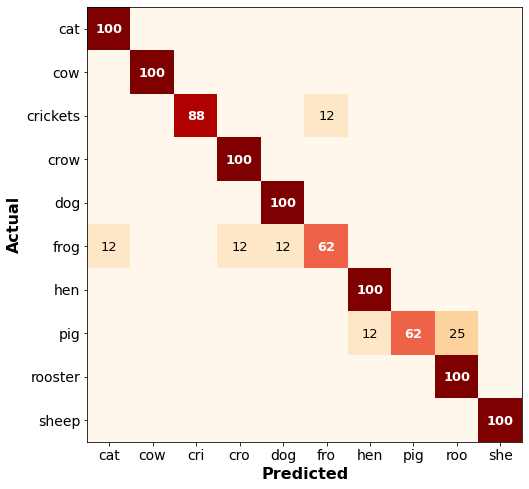

In [69]:
fig = plt.figure(figsize=(8,8))    
plt.imshow(conf, cmap=plt.cm.OrRd)
labels = []
labels_short = []
for label in target_classes:
    labels.append(str(label.replace('_', ' ')))
    labels_short.append(label[0:3])    
plt.yticks(range(len(target_classes)), labels, fontsize=14)
plt.xticks(range(len(target_classes)), labels_short, fontsize=14)
plt.ylabel('Actual', fontsize=16, fontweight="bold")
plt.xlabel('Predicted', fontsize=16, fontweight="bold")
for x in range(len(target_classes)):
    for y in range(len(target_classes)):
        if conf[y, x] > 0:
            plt.text(x, y + 0.1, "{:.0f}".format(conf[y, x]), 
                     fontsize=13, ha='center', 
                     color= 'white' if (x==y) else 'black', 
                     weight= 'bold' if (x==y) else 'normal')  

# Sound Event Detection

*The task of simultaneously estimating what is happening and when it is happening*

<img src="images/sed.png" width="400">

## System structure

A *simple* sound event detector can be implemented by applying a sound classifier or audio tagger in consecutive segments and joining activity information into sound events with start and end times.

- Model trained in the transfer learning section will be used
- Analysis is done in segments (0.96 sec) that are moved through the signal with 0.5-sec hops
- In each segment, the model is used to get class-wise scores
- Class with the highest score is outputted if the score is over the threshold (0.99)
- This system can detect only a single sound event at a time with a time resolution of 0.5 sec

## Example input signal

Signal generated with *dog*, *cat*, *rooster*, and *cow* samples in a metro station

In [72]:
# Create mixture with a dog, a cat, a rooster, and a cow

# Select samples
dog = test_pd.loc[test_pd['category'] == 'dog'].iloc[0]
cat = test_pd.loc[test_pd['category'] == 'cat'].iloc[3]
rooster = test_pd.loc[test_pd['category'] == 'rooster'].iloc[0]
cow = test_pd.loc[test_pd['category'] == 'cow'].iloc[1]

# Load samples
dog_audio = AudioContainer().load(filename=dog['filename'], fs=16000, mono=True).normalize().set_focus(start_seconds=0.2,stop_seconds=1).freeze()
cat_audio = AudioContainer().load(filename=cat['filename'], fs=16000, mono=True).normalize().set_focus(start_seconds=0.2,stop_seconds=1).freeze()
rooster_audio = AudioContainer().load(filename=rooster['filename'], fs=16000, mono=True).normalize().set_focus(start_seconds=0.8,stop_seconds=2.5).freeze()
cow_audio = AudioContainer().load(filename=cow['filename'], fs=16000, mono=True).normalize().set_focus(start_seconds=1.3,stop_seconds=2.5).freeze()

# Load background
audio_data = AudioContainer().load(
    filename=os.path.join('audio', 'metro_station-helsinki-67-1995-a.wav'), 
    fs=16000,
    mono=True
)

# Mix samples into background
audio_data.overlay(dog_audio, start_seconds=0.0, multiplier=0.25)
audio_data.overlay(cat_audio, start_seconds=1.0, multiplier=0.15)
audio_data.overlay(rooster_audio, start_seconds=2, multiplier=0.25)
audio_data.overlay(cow_audio, start_seconds=4.0, multiplier=0.25)

# Trim audio and normalize it
audio_data.set_focus(start_seconds=0,stop_seconds=8).freeze().normalize()

# Create reference metadata
current_meta = dcase_util.containers.MetaDataContainer(
    [
        {
            'event_label': 'dog',
            'event_onset': 0.0,
            'event_offset': 0.0 + dog_audio.duration_sec
            
        },
        {
            'event_label': 'cat',
            'event_onset': 1.0,
            'event_offset': 1.0 + cat_audio.duration_sec
            
        },
        {
            'event_label': 'rooster',
            'event_onset': 2.0,
            'event_offset': 2.0 + rooster_audio.duration_sec
            
        },
        {
            'event_label': 'cow',
            'event_onset': 4.0,
            'event_offset': 4.0 + cow_audio.duration_sec
            
        }      
    ]
)

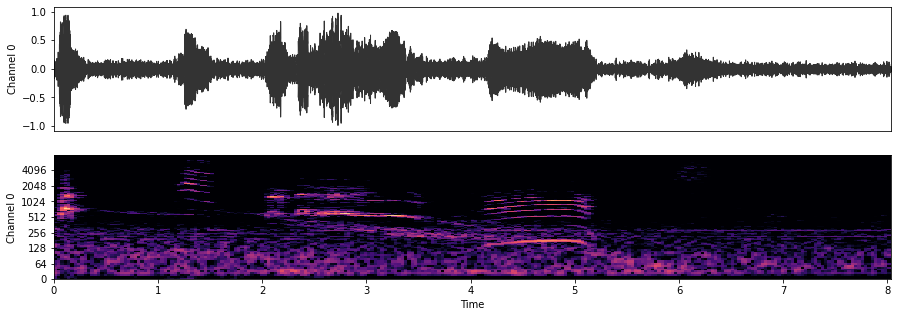

In [73]:
audio_data.plot(plot_type='dual', figsize=(15,5), show_filename=False)
display.Audio(audio_data.data,rate=audio_data.fs)

## Processing the signal

In [77]:
fs=16000
segment_hop= int(fs*0.5)
segment_length = int(fs*0.96)

results = dcase_util.containers.MetaDataContainer()
scores = np.zeros((int(np.ceil(len(audio_data.data)/segment_hop)), len(target_classes)))

In [78]:
for segment_id, segment_start in enumerate(range(0, len(audio_data.data), segment_hop)):
    segment_stop = segment_start + segment_length
    if segment_stop < audio_data.shape[0]: 
        current_results = finetuned_model(
            tf.convert_to_tensor(
                audio_data.data[segment_start:segment_stop], dtype=tf.float32
            )
        )        
        current_results = tf.nn.softmax(current_results, axis=-1)
        
        top_class_id = tf.argmax(current_results)
        top_score = current_results.numpy()[top_class_id]
        scores[segment_id] = current_results.numpy()
        
        if top_score > 0.99:
            inferred_class_label = target_classes[top_class_id]            
            results.append({
                'event_label': inferred_class_label,
                'event_onset': (segment_start/fs),
                'event_offset': (segment_stop/fs)                        
            })            
        else:        
            inferred_class_label = '---'

        print('[{onset:0.2f}s - {offset:0.2f}s] {label}\t {score:0.4f}'.format(
            onset=(segment_start/fs), offset=(segment_stop/fs),
            label=inferred_class_label, score=current_results.numpy()[top_class_id]
        ))

[0.00s - 0.96s] dog	 1.0000
[0.50s - 1.46s] cat	 0.9989
[1.00s - 1.96s] cat	 0.9996
[1.50s - 2.46s] ---	 0.7327
[2.00s - 2.96s] ---	 0.9805
[2.50s - 3.46s] rooster	 0.9987
[3.00s - 3.96s] ---	 0.8023
[3.50s - 4.46s] ---	 0.7105
[4.00s - 4.96s] ---	 0.9500
[4.50s - 5.46s] cow	 1.0000
[5.00s - 5.96s] ---	 0.7577
[5.50s - 6.46s] ---	 0.7507
[6.00s - 6.96s] ---	 0.3789
[6.50s - 7.46s] ---	 0.5927
[7.00s - 7.96s] ---	 0.7534


## System output versus reference

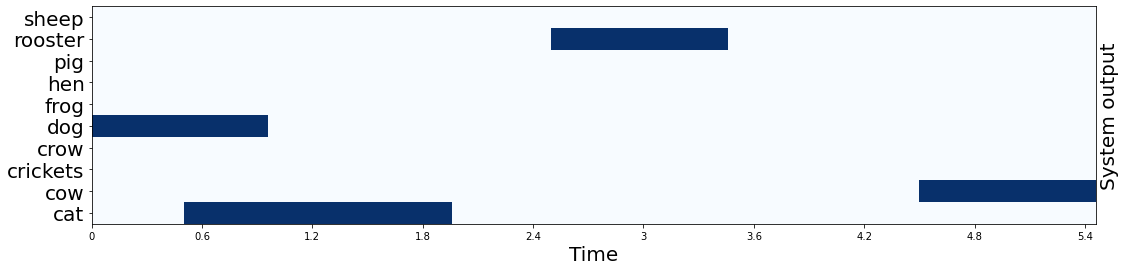

In [79]:
results.process_events().to_event_roll(label_list=target_classes).plot(
    figsize=(18,4), color='blue', plot=True, panel_title='System output'
)

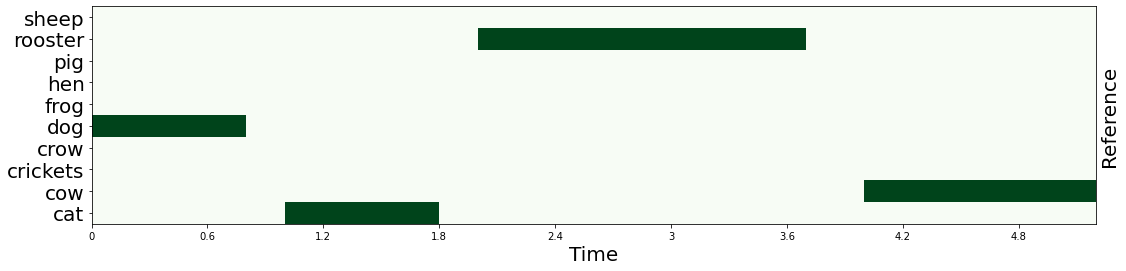

In [80]:
current_meta.to_event_roll(label_list=target_classes).plot(
    figsize=(18,4), color='green', plot=True, panel_title='Reference'
)